### Проверка влияния аугментированного датасета на качество предсказания моделей на примере логистической регрессии

#### Чтение аугментированного датасета

In [71]:
import pandas as pd

df = pd.read_csv('data/aug_dataset_15000.csv')
df.head()

,model_annotation,label
0,это вопрос это вспомнить надо,1
1,я кстати хочу вас познакомить с барием,0
2,кафе шишка слышу уже знать звонила,1
3,я ничего не пойму что вы от меня хотите,0
4,для закрытия,0


In [72]:
df.head()

,model_annotation,label
0,это вопрос это вспомнить надо,1
1,я кстати хочу вас познакомить с барием,0
2,кафе шишка слышу уже знать звонила,1
3,я ничего не пойму что вы от меня хотите,0
4,для закрытия,0


In [73]:
from transformers import AutoTokenizer, AutoModel
import torch

tokenizer = AutoTokenizer.from_pretrained("ai-forever/sbert_large_mt_nlu_ru",**{'padding':True, 'truncation':True, 'max_length':24, 'return_tensors':'pt'})
model = AutoModel.from_pretrained("ai-forever/sbert_large_mt_nlu_ru")

In [74]:
def mean_pooling(tokens, attention_mask):
    with torch.no_grad():
        output = model(**tokens)
    token_embeddings = output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

In [75]:
from torch import Tensor

def average_pool(last_hidden_states: Tensor,
                 attention_mask: Tensor) -> Tensor:
    last_hidden = last_hidden_states.masked_fill(~attention_mask[..., None].bool(), 0.0)
    return last_hidden.sum(dim=1) / attention_mask.sum(dim=1)[..., None]

### Токенизация

In [76]:
df['tokens'] = df['model_annotation'].apply(lambda x: tokenizer(x, padding=True, truncation=True, max_length=24, return_tensors='pt'))

In [13]:
test_df['tokens'] = test_df['model_annotation'].apply(lambda x: tokenizer(x, padding=True, truncation=True, max_length=24, return_tensors='pt'))

### Эмбеддинги

In [77]:
from tqdm import tqdm

tqdm.pandas()
df['sbert_emb'] = df['tokens'].progress_apply(lambda token: mean_pooling(token, token['attention_mask']))

100%|██████████| 15000/15000 [17:18<00:00, 14.44it/s]


In [14]:
from tqdm import tqdm

tqdm.pandas()
test_df['sbert_emb'] = test_df['tokens'].progress_apply(lambda token: mean_pooling(token, token['attention_mask']))

100%|██████████| 6508/6508 [08:27<00:00, 12.82it/s]


___
### Сохранение датафрейма с эмбеддингами

In [78]:
df.to_pickle('data/augmented_df_embeddings.pkl')

### Чтение датафрейма

In [79]:
import pandas as pd

df = pd.read_pickle('data/augmented_df_embeddings.pkl')
df.head()

,model_annotation,label,tokens,sbert_emb
0,это вопрос это вспомнить надо,1,"[input_ids, token_type_ids, attention_mask]","[[tensor(-0.0279), tensor(0.0810), tensor(-0.5..."
1,я кстати хочу вас познакомить с барием,0,"[input_ids, token_type_ids, attention_mask]","[[tensor(-0.0558), tensor(-0.5796), tensor(-1...."
2,кафе шишка слышу уже знать звонила,1,"[input_ids, token_type_ids, attention_mask]","[[tensor(-0.1637), tensor(-0.2485), tensor(-0...."
3,я ничего не пойму что вы от меня хотите,0,"[input_ids, token_type_ids, attention_mask]","[[tensor(-0.5920), tensor(-0.0873), tensor(-0...."
4,для закрытия,0,"[input_ids, token_type_ids, attention_mask]","[[tensor(0.5336), tensor(0.3480), tensor(-0.65..."


### Чтение исходного датасета с эмбеддингами

In [80]:
import pandas as pd

test_df = pd.read_pickle('data/init_df_embeddings.pkl')

___
### Разделение исходного датасета на тестовую и обучаемую выборки

In [94]:
## split test_df to test and train_add_df
from sklearn.model_selection import train_test_split

test_df, train_add_df = train_test_split(test_df, test_size=0.5, random_state=42)

test_df.to_pickle('data/test_df_embeddings.pkl')
train_add_df.to_pickle('data/train_add_df_embeddings.pkl')

### Объединим ауегментированный датасет с обучаемой частью исходного датасета

In [95]:
# concat train and train_add_df
train_df = pd.read_pickle('data/augmented_df_embeddings.pkl')
train_add_df = pd.read_pickle('data/train_add_df_embeddings.pkl')

train_df = pd.concat([train_df, train_add_df], ignore_index=True)

train_df.to_pickle('data/train_df_embeddings.pkl')

train_df.shape

(18254, 6)

### Удалим наблюдения, которые имеются в тестовой выборке

In [96]:
# delete rows from train where model_annotation exist in test
train_df = train_df[~train_df['model_annotation'].isin(test_df['model_annotation'])]
train_df.shape

(18057, 6)

In [97]:
X_train = train_df['sbert_emb']
y_train = train_df['label']

X_test = test_df['sbert_emb']
y_test = test_df['label']

In [98]:
X_train.shape, X_test.shape

((18057,), (3254,))

In [99]:
import numpy as np
import torch

X_train_ser = X_train.apply(lambda x: torch.reshape(x, shape=(1024,)).numpy())
X_test_ser = X_test.apply(lambda x: torch.reshape(x, shape=(1024,)).numpy())
y_train_arr = y_train.to_numpy()
y_test_arr = y_test.to_numpy()

In [100]:

def get_matrix(X: pd.Series) -> np.ndarray:
    X_train_matrix = np.zeros((X.shape[0], 1024))
    for i, array in enumerate(X):
        X_train_matrix[i] = array

    return X_train_matrix

X_train_matrix = get_matrix(X_train_ser)
X_test_matrix = get_matrix(X_test_ser)


___
### Модель

In [101]:
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from sklearn.base import BaseEstimator
import pickle
# import plt
import matplotlib.pyplot as plt

def visualize_and_save_results(model, model_name, X_train, X_test, y_train, y_test, out_dict):
    for data_name, X, y, model in [
    ('train', X_train, y_train, model),
    ('test', X_test, y_test, model)
    ]:
        if isinstance(model, BaseEstimator):
            proba = model.predict_proba(X)[:, 1]
        elif isinstance(model, nn.Module):
            proba = model(X).detach().cpu().numpy()[:, 1]
        else:
            raise ValueError('Unrecognized model type')
        # proba = model.predict(X)
        auc = roc_auc_score(y, proba)

        out_dict[f'{model_name}_{data_name}'] = auc
        plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (data_name, auc))
    out_dict['best_params'] = model.best_params_
    plt.plot([0, 1], [0, 1], '--', color='black',)
    plt.legend(fontsize='large')
    plt.title(model_name)
    plt.grid()
    
    pickle.dump(out_dict, open(f'data/{model_name}.pkl', 'wb'))
    
    return out_dict

___
### `LogisticRegression`

- #### L1

c:\Users\Davron\code\.venv\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


{'log_reg_sbert_l1_train': 0.822351462686514,
 'log_reg_sbert_l1_test': 0.7704513964850871,
 'best_params': {'C': 0.2,
  'max_iter': 5,
  'penalty': 'l1',
  'solver': 'liblinear'}}

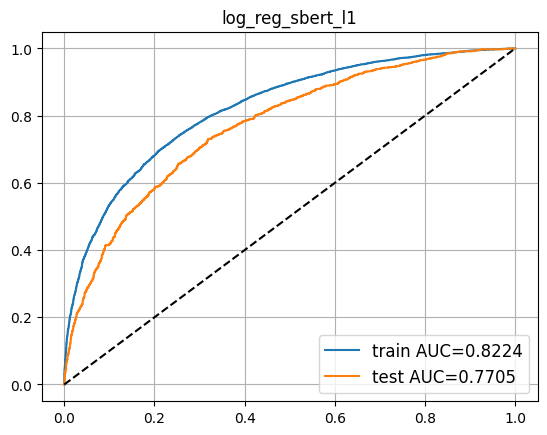

In [102]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from tqdm import tqdm


lr = LogisticRegression()

param_grid = {'penalty': ['l1'],
                'solver':['liblinear'],
                'max_iter': [3, 4, 5],
                'C':[0.2, 0.3, 0.4]}
gs = GridSearchCV(estimator=lr, param_grid=param_grid, cv=StratifiedKFold(5), scoring='roc_auc', n_jobs=2, return_train_score=True)
gs.fit(X_train_matrix, y_train_arr)


out_dict = {}
out_dict = visualize_and_save_results(gs, 'log_reg_sbert_l1', X_train_matrix, X_test_matrix, y_train, y_test, out_dict)
out_dict

In [40]:
def get_metrics(gs, out_dict: dict) -> dict:
    """Сбор параметров и метрик обученной модели

    Args:
        gs (_type_): Экземпляр класса GridSearchCV после обучения
        out_dict (dict): Словарь с метриками на тесте и лучшими параметрами модели

    Returns:
        dict: Обновленный словарь со средними метриками на обучающей и валидационной выборках
    """
    
    val_auc = gs.best_score_
    metrics_df = pd.DataFrame(gs.cv_results_)
    total_main_metrics = metrics_df[['mean_train_score', 'mean_test_score', 'std_test_score']]
    main_metrics_dict = total_main_metrics[total_main_metrics['mean_test_score'] == val_auc].to_dict()
    out_dict.update(**main_metrics_dict)
    return out_dict

out_dict = get_metrics(gs, out_dict)
out_dict

{'log_reg_sbert_l1_train': 0.8372332399082769,
 'log_reg_sbert_l1_test': 0.741393171457422,
 'best_params': {'C': 0.2,
  'max_iter': 4,
  'penalty': 'l1',
  'solver': 'liblinear'},
 'mean_train_score': {1: 0.840568764562039},
 'mean_test_score': {1: 0.7822414181365438},
 'std_test_score': {1: 0.008674468936667314}}

In [33]:
from catboost import CatBoostClassifier as CatBoost
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from tqdm import tqdm

# limit number of trees
model = CatBoost()

param_grid = {'learning_rate': [0.1, 0.3],
            'depth': [1],
            'iterations': [500],
            'l2_leaf_reg': [1, 3]}

gs = GridSearchCV(estimator=model, param_grid=param_grid, cv=StratifiedKFold(5), scoring='roc_auc', n_jobs=4, verbose=1)
gs.fit(X_train_matrix, y_train_arr)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
0:	learn: 0.6902343	total: 7.54ms	remaining: 3.76s
1:	learn: 0.6875519	total: 13.8ms	remaining: 3.44s
2:	learn: 0.6852865	total: 20ms	remaining: 3.32s
3:	learn: 0.6829341	total: 26.6ms	remaining: 3.3s
4:	learn: 0.6811469	total: 33ms	remaining: 3.27s
5:	learn: 0.6792279	total: 39.4ms	remaining: 3.24s
6:	learn: 0.6770270	total: 45.6ms	remaining: 3.21s
7:	learn: 0.6752382	total: 51.5ms	remaining: 3.17s
8:	learn: 0.6735288	total: 58.7ms	remaining: 3.2s
9:	learn: 0.6716228	total: 64.8ms	remaining: 3.17s
10:	learn: 0.6701674	total: 71.5ms	remaining: 3.18s
11:	learn: 0.6685060	total: 78.3ms	remaining: 3.18s
12:	learn: 0.6669602	total: 85ms	remaining: 3.18s
13:	learn: 0.6652357	total: 91ms	remaining: 3.16s
14:	learn: 0.6639125	total: 97.1ms	remaining: 3.14s
15:	learn: 0.6626027	total: 104ms	remaining: 3.15s
16:	learn: 0.6612605	total: 111ms	remaining: 3.15s
17:	learn: 0.6598163	total: 117ms	remaining: 3.13s
18:	learn: 0.6586594	total:

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=<catboost.core.CatBoostClassifier object at 0x0000020148F77210>,
             n_jobs=4,
             param_grid={'depth': [1], 'iterations': [500],
                         'l2_leaf_reg': [1, 3], 'learning_rate': [0.1, 0.3]},
             scoring='roc_auc', verbose=1)

{'CatBoost_sbert_train': 0.8160090269346448,
 'CatBoost_sbert_test': 0.7731146809460063,
 'best_params': {'depth': 1,
  'iterations': 500,
  'l2_leaf_reg': 3,
  'learning_rate': 0.1}}

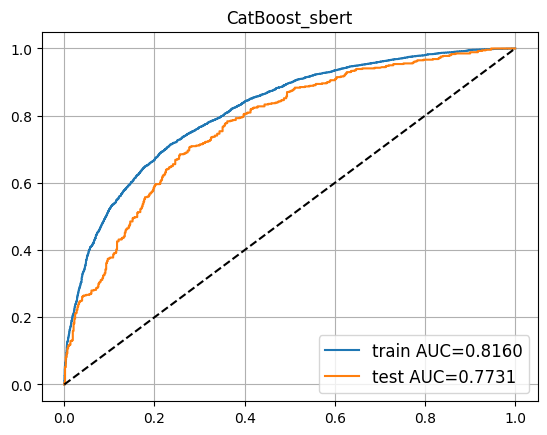

In [34]:
out_dict = {}
out_dict = visualize_and_save_results(gs, 'CatBoost_sbert', X_train_matrix, X_test_matrix, y_train, y_test, out_dict)
out_dict

### Вывод:
Аугментированный датасет не дал ожидаемого буста (улучшения) в качестве предсказания модели. Логистическая регрессия с L1 регуляризацией дала результаты: 0.7705 на тестовой выборке, 0.782 средний ROC-AUC на валидационных фолдах. 
Алгоритм CatBoost улучшил ROC-AUC с 0.772 на 0.773 при аугментации данных, что всё равно меньше результата нейронной сети (0.806).